# M5 Forecasting Accuracy Research
This is a continuation of my work on analyzing the sales data of Walmart's TX_1 store (Version 1 found here:https://www.kaggle.com/jimmyliuu/m5-forecast-accuracy-research-version-1). This week, I explore the capabilities of Facebook Prophet, a forecasting procedure based on an additive model where non-linear trends are fit on daily, weekly, and yearly seasonality with the effects of holidays. (reference: https://facebook.github.io/prophet)

I followed Ruan van der Merwe's "Implementing Facebook Prophet efficiently" to implement fbprophet effectively (reference: https://towardsdatascience.com/implementing-facebook-prophet-efficiently-c241305405a3)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/m5-forecasting-accuracy/sample_submission.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv
/kaggle/input/m5-forecasting-accuracy/calendar.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv
/kaggle/input/m5-forecasting-accuracy/sell_prices.csv


# Load and Prep Data

In [2]:
CalendarDF=pd.read_csv("/kaggle/input/m5-forecasting-accuracy/calendar.csv", header=0)
SalesDF=pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv", header=0) #June 1st Dataset
CalendarDF['date'] = pd.to_datetime(CalendarDF.date)

TX_1_Sales = SalesDF[['TX_1' in x for x in SalesDF['store_id'].values]]
TX_1_Sales = TX_1_Sales.reset_index(drop = True)

# Generate MultiIndex for easier aggregration.
TX_1_Indexed = pd.DataFrame(TX_1_Sales.groupby(by = ['cat_id','dept_id','item_id']).sum())

# Aggregate total sales per day for each sales category
Food = pd.DataFrame(TX_1_Indexed.xs('FOODS').sum(axis = 0))
Hobbies = pd.DataFrame(TX_1_Indexed.xs('HOBBIES').sum(axis = 0))
Household = pd.DataFrame(TX_1_Indexed.xs('HOUSEHOLD').sum(axis = 0))

# Merge the aggregated sales data to the calendar dataframe based on date
CalendarDF = CalendarDF.merge(Food, how = 'left', left_on = 'd', right_on = Food.index)
CalendarDF = CalendarDF.rename(columns = {0:'Food'})
CalendarDF = CalendarDF.merge(Hobbies, how = 'left', left_on = 'd', right_on = Hobbies.index)
CalendarDF = CalendarDF.rename(columns = {0:'Hobbies'})
CalendarDF = CalendarDF.merge(Household, how = 'left', left_on = 'd', right_on = Household.index)
CalendarDF = CalendarDF.rename(columns = {0:'Household'})

# Drop dates with null sales data
CalendarDF = CalendarDF.drop(CalendarDF.index[1941:])
CalendarDF.reset_index(drop = True)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,Food,Hobbies,Household
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,1781.0,251.0,524.0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,1903.0,264.0,520.0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,1377.0,107.0,338.0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,1643.0,248.0,367.0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,1329.0,102.0,263.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936,2016-05-18,11616,Wednesday,5,5,2016,d_1937,NaN,NaN,NaN,NaN,0,0,0,1924.0,257.0,966.0
1937,2016-05-19,11616,Thursday,6,5,2016,d_1938,NaN,NaN,NaN,NaN,0,0,0,1764.0,229.0,755.0
1938,2016-05-20,11616,Friday,7,5,2016,d_1939,NaN,NaN,NaN,NaN,0,0,0,2384.0,281.0,999.0
1939,2016-05-21,11617,Saturday,1,5,2016,d_1940,NaN,NaN,NaN,NaN,0,0,0,2604.0,386.0,1177.0


# Modify Food Data to be Compatible with fbprophet

fbprophet only takes in data in the format ['y','ds']

In [3]:
# Add a 'ds' column into the Food dataframe
Food['date'] = CalendarDF['date'].values
Food.columns = ['y','ds']

# Create Train and Test datasets
FoodTrain = Food[0:1899]
FoodTest = Food[1899:1941]

In [4]:
# MAPE
def mean_absolute_percentage_error(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    return np.mean(np.abs((actual - predicted)/actual)) * 100

# Creating the Prophet Model

MAPE: 11.621051688823837


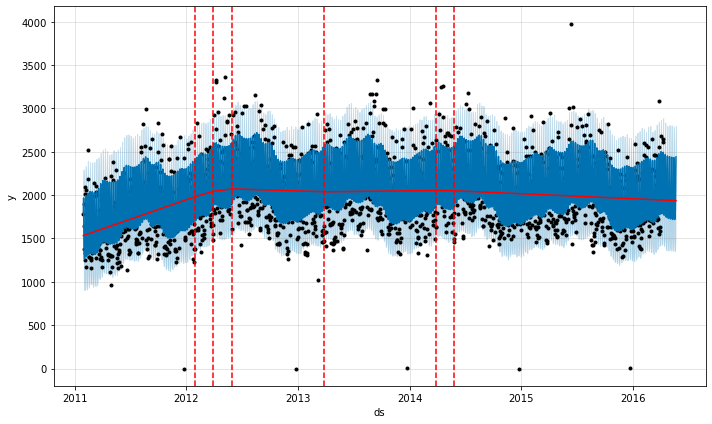

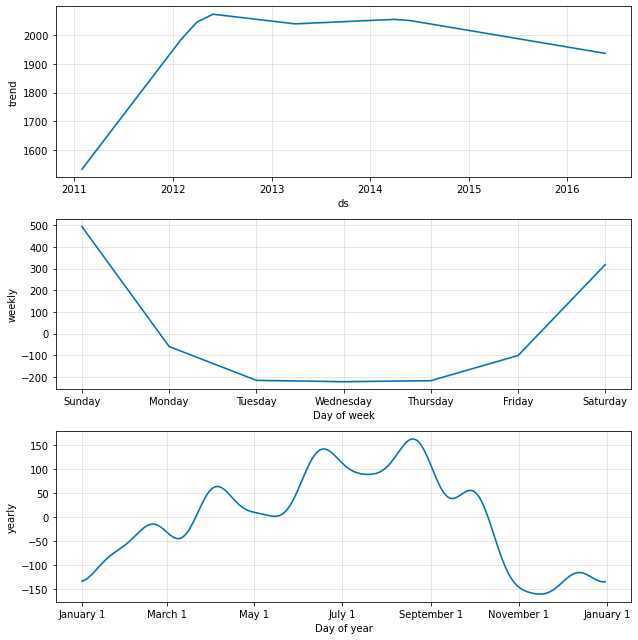

In [5]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

# using the 'out of box' Prophet settings
prophet = Prophet()
prophet.fit(FoodTrain)
future = prophet.make_future_dataframe(periods = 42, freq = 'd')
forecast = prophet.predict(future)

# plotting the forecast with changepoints and the components
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
fig2 = prophet.plot_components(forecast)

# MAPE of the 'out of box' Prophet
print('MAPE: ' + str(mean_absolute_percentage_error(FoodTest.y.values, forecast.yhat.iloc[1899:1941].values)))

# Incorporating holidays
Here, I use the US holidays built into fbprophet and use event_name_1 as holidays to see if there is any forecasting improvement. I use Greg Rafferty's "Forecasting in Python with Facebook Prophet" as a guide (reference: https://towardsdatascience.com/forecasting-in-python-with-facebook-prophet-29810eb57e66)

MAPE: 11.7878280249898


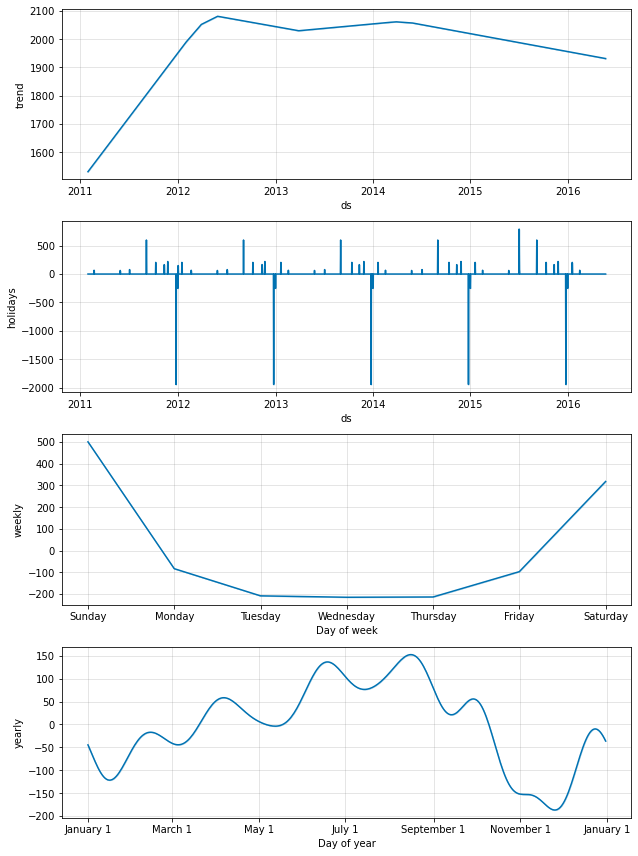

In [6]:
# incorporating US holidays
prophet = Prophet()
prophet.add_country_holidays(country_name='US')
prophet.fit(FoodTrain)
future = prophet.make_future_dataframe(periods = 42, freq = 'd')
forecast = prophet.predict(future)

# since the forecast will remain relatively unchanged, I only plot the components
fig2 = prophet.plot_components(forecast)

# MAPE
print('MAPE: ' + str(mean_absolute_percentage_error(FoodTest.y.values, forecast.yhat.iloc[1899:1941].values)))

MAPE: 11.710727265757791


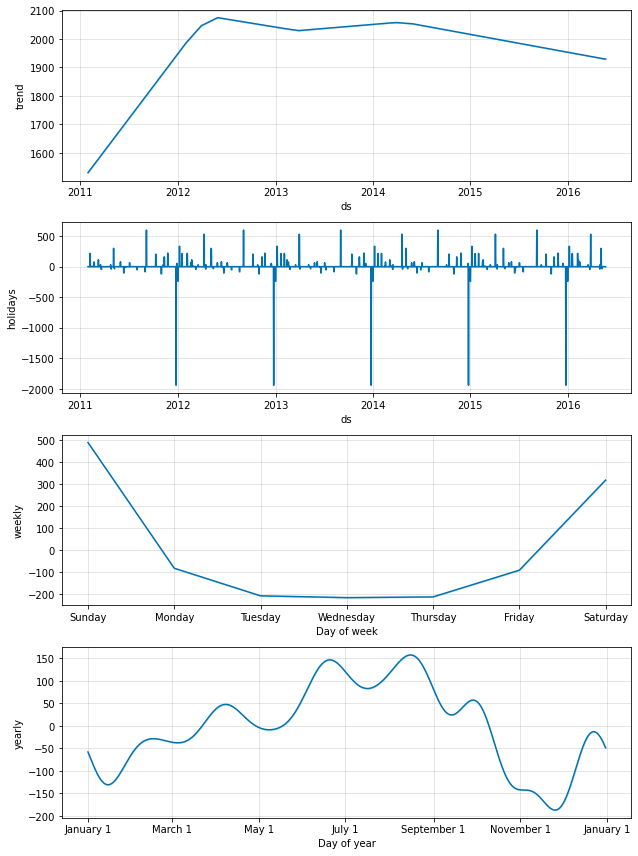

In [7]:
# incorporating event_name_1 as 'holidays'
holidays = pd.DataFrame()

holidays = CalendarDF[CalendarDF.event_name_1.notnull()]
holidays = holidays[['date','event_name_1']]

# formatting column names
holidays.columns = ['ds','holiday']

prophet = Prophet(holidays = holidays)
prophet.fit(FoodTrain)
forecast = prophet.predict(future)

# plotting only components
fig2 = prophet.plot_components(forecast)

# MAPE
print('MAPE: ' + str(mean_absolute_percentage_error(FoodTest.y.values, forecast.yhat.iloc[1899:1941].values)))

The holiday component shows how you can expect the sales data to fluctuate based on certain holidays. The large drops are always on Christmas, as there are always no sales during that date (with the store being closed). It seems that both incorporating US holidays and event_name_1 holidays produce forecasts slightly worse than the 'out of box' Prophet.

# Adding Custom Seasonality
The 'out of box' Prophet automatically incorporates seasonality. However, you are able to customize your seasonality as well. I attempt to tweak the weekly seasonality to see the effects on forecast accuracy.

MAPE: 11.697051237488576


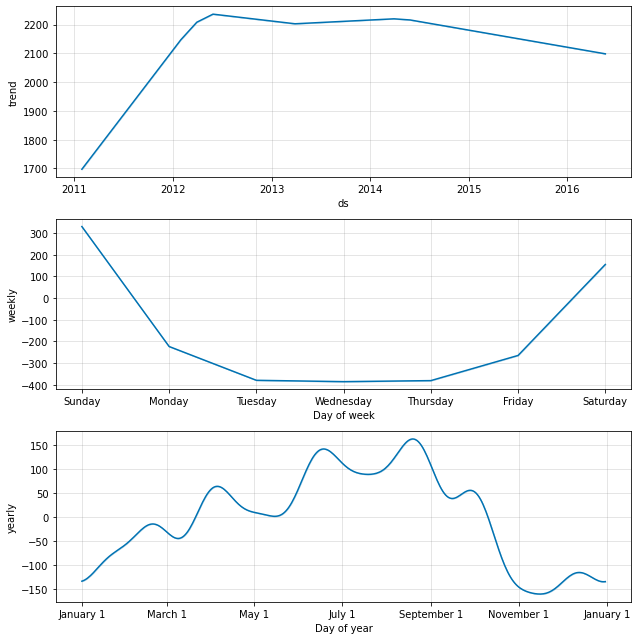

In [8]:
# adjusting weekly seasonality while keeping 'out of box' yearly seasonality
prophet = Prophet(weekly_seasonality = False, yearly_seasonality = True).add_seasonality(name = 'weekly', period = 7, fourier_order = 20)
prophet.fit(FoodTrain)
future = prophet.make_future_dataframe(periods = 42, freq = 'd')
forecast = prophet.predict(future)

# plotting components
fig2 = prophet.plot_components(forecast)

# MAPE
print('MAPE: ' + str(mean_absolute_percentage_error(FoodTest.y.values, forecast.yhat.iloc[1899:1941].values)))

Adjusting only the weekly seasonality keeps the forecast nearly unchanged from 'out of box' forecast's accuracy.

MAPE: 11.596743422261222


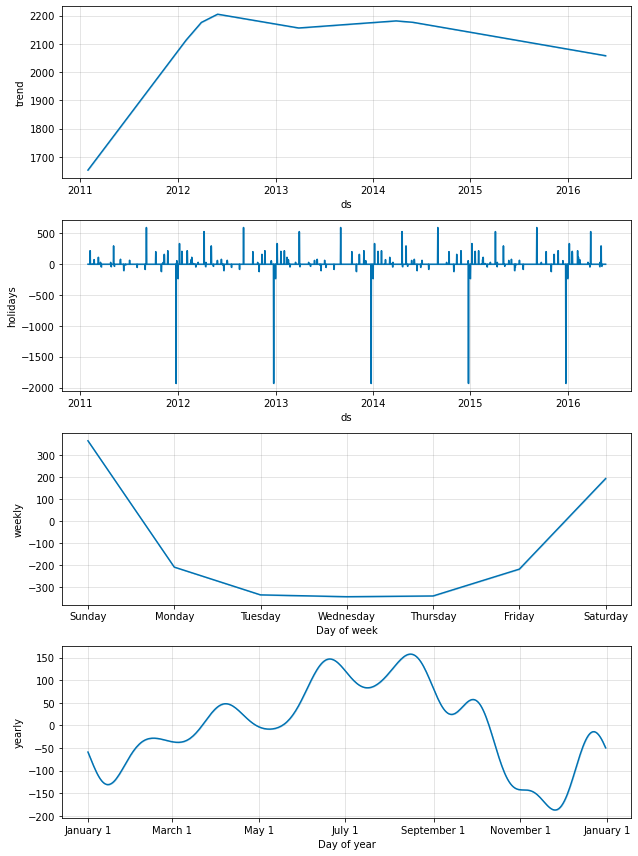

In [9]:
# Combining all tweaks to the model

prophet = Prophet(holidays = holidays, weekly_seasonality = False).add_seasonality(name = 'weekly', period = 7, fourier_order = 10)
prophet.fit(FoodTrain)
forecast = prophet.predict(future)

# plotting only components
fig2 = prophet.plot_components(forecast)

# MAPE
print('MAPE: ' + str(mean_absolute_percentage_error(FoodTest.y.values, forecast.yhat.iloc[1899:1941].values)))

The MAPE improves by less than .1%, showing that the 'out of box' prophet is already extremely effective at performing time series analysis.

fbprophet is much faster than the ARIMA models and the LSTM models. It also seems to forecast future values relatively accurately. Overall, fbprophet is a simple and powerful tool. It is easy to implement without much knowledge of time series analysis.